In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = "data/raw/processed_images"

# Dimensions standardisées
img_height, img_width = 128, 128
batch_size = 32

# Générateurs d'images avec normalisation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# load mobilenetV2 without last layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # freezing the base model

# adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Dropout pour éviter l'overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binaire : cataracte ou pas

# create & compile final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# display model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

2025/04/23 13:53:41 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/04/23 13:53:41 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\Users\hiron\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 851ms/step - accuracy: 0.5074 - loss: 0.9445 - val_accuracy: 0.8430 - val_loss: 0.4368
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step - accuracy: 0.7490 - loss: 0.4939 - val_accuracy: 0.9339 - val_loss: 0.2724
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - accuracy: 0.8372 - loss: 0.3618 - val_accuracy: 0.9587 - val_loss: 0.2001
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 682ms/step - accuracy: 0.8831 - loss: 0.3070 - val_accuracy: 0.9504 - val_loss: 0.1655
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 672ms/step - accuracy: 0.8944 - loss: 0.2539 - val_accuracy: 0.9421 - val_loss: 0.1445
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step - accuracy: 0.9114 - loss: 0.2331 - val_accuracy: 0.9587 - val_loss: 0.1361
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 0.9134 - loss: 0.2094 - val_accuracy: 0.9504 - val_loss: 0.1227
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 651ms/step - accuracy: 0.9352 - loss: 0.1590 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.9647 - loss: 0.0942
Test Accuracy: 0.96


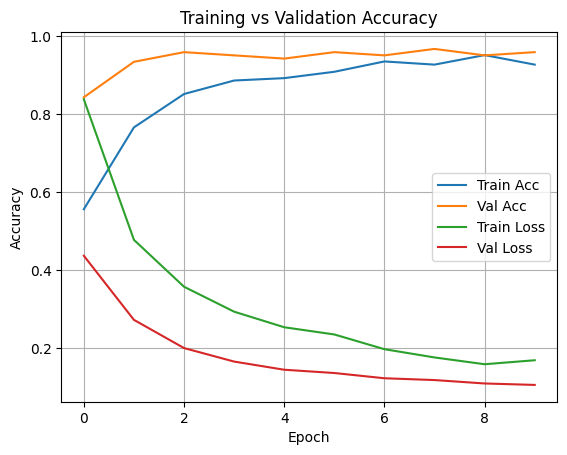

In [7]:
import mlflow.keras, time
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

# set mlflow experiment
mlflow.set_experiment("cataract_classification")

# create a tensorboard callback
log_dir = f"logs/cnn_mobilnet_{int(time.time())}"
tensorboard_callback = TensorBoard(log_dir=log_dir)

with mlflow.start_run(run_name="MobilnetV2_Model"):
    mlflow.keras.autolog()

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[tensorboard_callback]
    )

    model.save("cataract_mobilnetv2_classifier.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()

2025/04/23 13:55:48 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/04/23 13:55:48 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.7620 - loss: 0.4513 - val_accuracy: 0.9504 - val_loss: 0.0978
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 698ms/step - accuracy: 0.8796 - loss: 0.2847 - val_accuracy: 0.9504 - val_loss: 0.0953
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.9230 - loss: 0.2107 - val_accuracy: 0.9587 - val_loss: 0.0945
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 703ms/step - accuracy: 0.9248 - loss: 0.1943 - val_accuracy: 0.9669 - val_loss: 0.0930
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 666ms/step - accuracy: 0.9371 - loss: 0.1618 - val_accuracy: 0.9669 - val_loss: 0.0919
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 691ms/step - accuracy: 0.9545 - loss: 0.1521 - val_accuracy: 0.9669 - val_loss: 0.0890
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 658ms/step - accuracy: 0.9679 - loss: 0.1261 - val_accuracy: 0.9669 - val_loss: 0.0871
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 681ms/step - accuracy: 0.9552 - loss: 0.1386 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.9649 - loss: 0.0920
Test Accuracy: 0.97


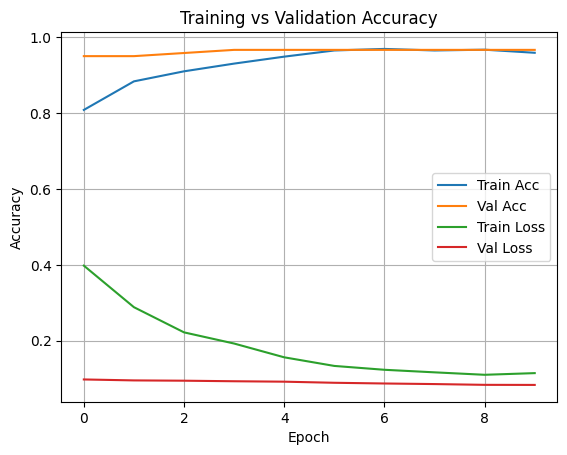

In [8]:
# unlock the base model for fine-tuning
base_model.trainable = True

# fine-tune the last 30 layers of the base model
for layer in base_model.layers[:-30]:
    layer.trainable = False

# compile the model again
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

with mlflow.start_run(run_name="MobilnetV2_Model"):
    mlflow.keras.autolog()

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[tensorboard_callback]
    )

    model.save("cataract_mobilnetv2_finetuned_classifier.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()
